# Python Group
## Lab Two: Exploring Image Data
### Wali Chaudhary, Bryce Shurts, & Alex Wright

## 1. Business Understanding

# TODO

### Citation & Acknowledgement
The Hotels Reservation dataset is liscenced under the [GNU General Public License, version 2](https://www.gnu.org/licenses/old-licenses/gpl-2.0.en.html) and was provided by Preet Viradiya on [Kaggle](https://www.kaggle.com/datasets/preetviradiya/brian-tumor-dataset).

## 2. Data Preperation

In [209]:
# Handle all imports for notebook

# Generic list pulled from last project, modify as desired
import pandas as pd
from pandas import ( DataFrame, Series )
import numpy as np
from numpy import ndarray
import os
from os import listdir
from os.path import isfile, join
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import random
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [210]:
df: DataFrame = pd.read_csv("metadata.csv")

In [211]:
df.head()

,Unnamed: 0,image,class,format,mode,shape
0,0,Cancer (1).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
1,1,Cancer (1).png,tumor,PNG,L,"(300, 240)"
2,2,Cancer (1).tif,tumor,TIFF,RGB,"(256, 256, 3)"
3,3,Cancer (10).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
4,4,Cancer (10).tif,tumor,TIFF,RGB,"(256, 256, 3)"


Immediately we can see that we have an unnamed title with a set of IDS, which can be safely removed

In [212]:
df.drop("Unnamed: 0", axis=1, inplace=True)
df.head()

,image,class,format,mode,shape
0,Cancer (1).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
1,Cancer (1).png,tumor,PNG,L,"(300, 240)"
2,Cancer (1).tif,tumor,TIFF,RGB,"(256, 256, 3)"
3,Cancer (10).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
4,Cancer (10).tif,tumor,TIFF,RGB,"(256, 256, 3)"


It looks like the images are not particularly uniform in composition. Let's investigate further.

Resolutions by count:
 (512, 512, 3)    884
(225, 225, 3)    364
(630, 630, 3)    126
(256, 256, 3)    105
(236, 236, 3)     89
                ... 
(201, 236, 3)      1
(222, 233, 3)      1
(294, 236, 3)      1
(244, 235, 3)      1
(454, 442, 4)      1
Name: shape, Length: 475, dtype: int64


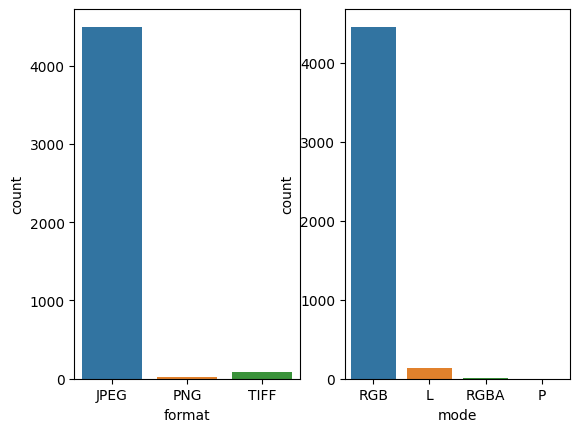

In [213]:
fig, ax = plt.subplots(1,2)
sns.countplot(x="format", data=df, ax=ax[0])
sns.countplot(x="mode", data=df, ax=ax[1])
print("Resolutions by count:\n", df["shape"].value_counts())
# Way too many resolutions to plot...
#sns.countplot(x="shape", data=df, ax=ax[2])
plt.show()

We can see that we have a few different images that are not in the JPEG format and/or are not using the RGB color mode, which are both the most common. Since conversions would be computationally expensive and lossy, and since the number of images that are in the wrong format is relatively few, they will be dropped.

In [214]:
bad_columns = df[(df["format"] != "JPEG") | (df["mode"] != "RGB") | ((df["shape"] != "(512, 512, 3)") & (df["shape"] != "(256, 256, 3)") & (df["shape"] != "(225, 225, 3)") & (df["shape"] != "(630, 630, 3)") & (df["shape"] != "(236, 236, 3)"))]
df.drop(bad_columns.index, inplace=True)
bad_columns = bad_columns["image"] # For later deletion

In [216]:
print(bad_columns)

1              Cancer (1).png
2              Cancer (1).tif
4             Cancer (10).tif
6           Cancer (1000).jpg
7           Cancer (1001).jpg
                ...          
4595    Not Cancer  (995).jpg
4596    Not Cancer  (996).jpg
4597    Not Cancer  (997).jpg
4598    Not Cancer  (998).jpg
4599    Not Cancer  (999).jpg
Name: image, Length: 3118, dtype: object


In [217]:
files = [file for file in listdir("Brain Tumor Data Set/Brain Tumor/") if isfile(join("Brain Tumor Data Set/Brain Tumor/", file))] + [file for file in listdir("Brain Tumor Data Set/Healthy/") if isfile(join("Brain Tumor Data Set/Healthy/", file))]
bad_files = [file for file in files if file in bad_columns.tolist()]
for file in bad_files:
    if "Not" in file:
        os.remove(join("Brain Tumor Data Set/Healthy/", file))
    else:
        os.remove(join("Brain Tumor Data Set/Brain Tumor/", file))

In [218]:
# Define data types
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1482 entries, 0 to 4585
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   1482 non-null   object
 1   class   1482 non-null   object
 2   format  1482 non-null   object
 3   mode    1482 non-null   object
 4   shape   1482 non-null   object
dtypes: object(5)
memory usage: 69.5+ KB


In [221]:
# Thoughts on what to do with resolutions? I say convert all to the smallest dimension (225x225) and then delete everything else
from skimage.transform import resize
from matplotlib import image

cancer_images = []
healthy_images = []
images = [file for file in listdir("Brain Tumor Data Set/Brain Tumor/") if isfile(join("Brain Tumor Data Set/Brain Tumor/", file))] + [file for file in listdir("Brain Tumor Data Set/Healthy/") if isfile(join("Brain Tumor Data Set/Healthy/", file))]
for image in images:
    if "Not" in image:
        cancer_images.append(plt.imread(join("Brain Tumor Data Set/Healthy/", image)))
    else:
        healthy_images.append(plt.imread(join("Brain Tumor Data Set/Brain Tumor/", image)))